# Time-Series Forecasting for Electricity Load (value_0)

## Introduction
In this notebook, we build short-term forecasting models for electricity load using historical lag features.  
We focus on a single meter (value_0) and compare three models:

- Linear Regression (baseline)
- Lasso Regression
- XGBoost Regressor

The goal is to predict the next 15-minute electricity load based on past observations.  

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_pickle("../data/cleaned_data.pkl")
df.head()

,id_series,date,value_0,value_1,value_2,value_3,value_4,value_5,value_6,value_7,...,value_311,value_312,value_313,value_314,value_315,time_step,hour,day,month,weekday
0,0,2012-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,1,6
1,0,2012-01-01 00:15:00,3.807107,22.759602,77.324066,136.178862,70.731707,351.190476,9.609949,279.461279,...,15.645372,12.873025,504.828797,63.439065,761.730205,1,0,1,1,6
2,0,2012-01-01 00:30:00,5.076142,22.759602,77.324066,136.178862,73.170732,354.166667,9.044658,279.461279,...,15.645372,13.458163,525.021949,60.100167,702.346041,2,0,1,1,6
3,0,2012-01-01 00:45:00,3.807107,22.759602,77.324066,140.243902,69.512195,348.214286,8.479367,279.461279,...,15.645372,10.532475,526.777875,56.761269,696.480938,3,0,1,1,6
4,0,2012-01-01 01:00:00,3.807107,22.759602,77.324066,140.243902,75.609756,339.285714,7.348785,279.461279,...,15.645372,14.628438,539.947322,63.439065,693.548387,4,1,1,1,6


## Select One Meter and Build Time-Series Structure

We focus on meter value_0 only.
To prepare the data for time-series forecasting, we combine the date and time_step columns into a single timestamp column.

We then keep only:
- timestamp
- value_0

These two fields represent the time series we will forecast.

In [5]:
ts = df[["date", "time_step", "value_0"]].copy()

ts["timestamp"] = ts["date"] + pd.to_timedelta(ts["time_step"])

ts = ts.sort_values("timestamp").reset_index(drop=True)
ts = ts[["timestamp", "value_0"]]
ts.head()

,timestamp,value_0
0,2012-01-01 00:00:00.000000000,0.000000
1,2012-01-01 00:15:00.000000001,3.807107
2,2012-01-01 00:30:00.000000002,5.076142
3,2012-01-01 00:45:00.000000003,3.807107
4,2012-01-01 01:00:00.000000004,3.807107


## Create Lag Features

To forecast the next time step’s load, we create features that represent previous values:
- lag_1: value from 1 interval ago (15 minutes)
- lag_24: value from 24 intervals ago (6 hours)
- lag_96: value from 96 intervals ago (24 hours)

lag_1 captures short-term dependence, lag_24 captures mid-range behavior, and lag_96 captures daily periodic behavior.

We also add rolling statistics:
- rolling_mean_24
- rolling_std_24

Finally, we drop rows with missing values created by the lag/rolling operations.

In [6]:
ts["lag_1"] = ts["value_0"].shift(1)      
ts["lag_24"] = ts["value_0"].shift(24)   
ts["lag_96"] = ts["value_0"].shift(96) 

In [7]:
ts["rolling_mean_24"] = ts["value_0"].rolling(24).mean()
ts["rolling_std_24"] = ts["value_0"].rolling(24).std()

In [8]:
ts = ts.dropna().reset_index(drop=True)

In [9]:
ts.head()

,timestamp,value_0,lag_1,lag_24,lag_96,rolling_mean_24,rolling_std_24
0,2012-01-02 00:00:00.000000096,3.807107,3.807107,17.766497,0.000000,11.262690,6.623899
1,2012-01-02 00:15:00.000000097,3.807107,3.807107,17.766497,3.807107,10.681049,6.640835
2,2012-01-02 00:30:00.000000098,3.807107,3.807107,17.766497,5.076142,10.099408,6.604491
3,2012-01-02 00:45:00.000000099,3.807107,3.807107,19.035533,3.807107,9.464890,6.438066
4,2012-01-02 01:00:00.000000100,3.807107,3.807107,7.614213,3.807107,9.306261,6.531867


## Chronological Train/Test Split

Time-series forecasting must respect temporal order.
We split the dataset:
- 80% for training
- 20% for testing

No shuffling is used since future values must not leak into training.

We define:
- X_train, y_train for model fitting
- X_test, y_test for forecasting and evaluation

In [10]:
split_idx = int(len(ts) * 0.8)

train = ts.iloc[:split_idx].copy()
test = ts.iloc[split_idx:].copy()

In [11]:
features = ["lag_1", "lag_24", "lag_96", "rolling_mean_24", "rolling_std_24"]

X_train = train[features]
y_train = train["value_0"]

X_test = test[features]
y_test = test["value_0"]

In [12]:
X_train.shape, X_test.shape

((84096, 5), (21025, 5))

## Baseline Model: Linear Regression
Linear Regression provides a simple baseline.
It assumes a linear relationship between lagged features and the future load.

We:
- Fit the model on training data
- Predict load on test data
- Compute RMSE (Root Mean Squared Error)
- Plot Actual vs Forecasted values

This baseline helps evaluate whether more complex models are necessary.

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Train baseline Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on test set
pred_lr = lr.predict(X_test)

# Compute RMSE
mse_lr = mean_squared_error(y_test, pred_lr)
rmse_lr = np.sqrt(mse_lr)
rmse_lr


np.float64(2.1809428971134337)

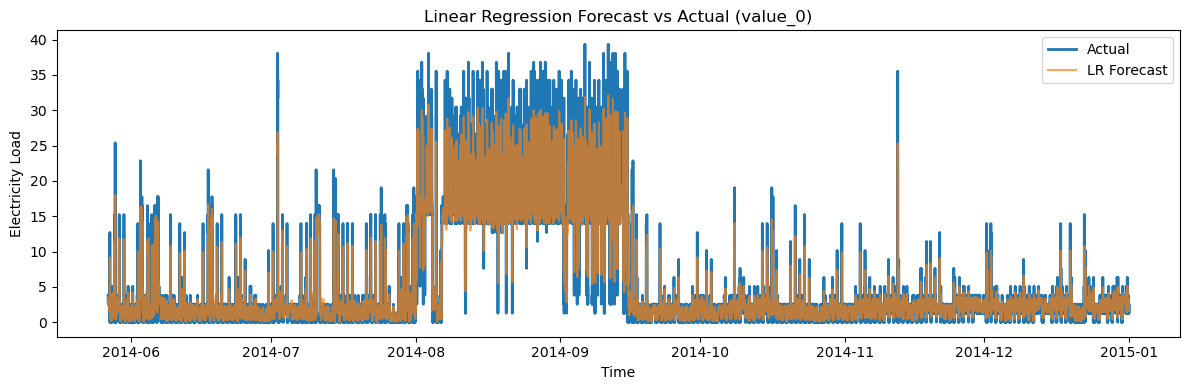

In [14]:
plt.figure(figsize=(12,4))
plt.plot(test["timestamp"], y_test, label="Actual", linewidth=2)
plt.plot(test["timestamp"], pred_lr, label="LR Forecast", alpha=0.7)
plt.legend()
plt.title("Linear Regression Forecast vs Actual (value_0)")
plt.xlabel("Time")
plt.ylabel("Electricity Load")
plt.tight_layout()
plt.show()

## Lasso Regression Model

Lasso Regression includes L1 regularization, which can:
- Reduce overfitting
- Remove irrelevant lag features by forcing coefficients to zero

This makes Lasso a useful alternative to the baseline model.
We train Lasso, compute RMSE, and compare performance.

In [15]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Train Lasso model
lasso = Lasso(alpha=0.001, max_iter=5000)
lasso.fit(X_train, y_train)

# Predict
pred_lasso = lasso.predict(X_test)

# RMSE 
rmse_lasso = np.sqrt(mean_squared_error(y_test, pred_lasso))
rmse_lasso

np.float64(2.180940870171899)

## XGBoost Model

XGBoost is a nonlinear tree-based model that often performs well on structured time-series data.
It can learn complex relationships that linear models cannot capture.

We train an XGBRegressor with simple, student-level parameters and evaluate its forecasting RMSE.

In [16]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

xgb = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

# Fit model
xgb.fit(X_train, y_train)

# Predict
pred_xgb = xgb.predict(X_test)

# Compute RMSE 
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
rmse_xgb

np.float64(2.0285786819329097)

## RMSE Comparison Across Models

We compare RMSE values for:

| **Model**           | **Description**              |
|---------------------|------------------------------|
| Linear Regression   | Simple baseline              |
| Lasso               | Regularized linear model     |
| XGBoost             | Nonlinear boosted trees      |

A lower RMSE indicates better predictive performance.

In [17]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["LR (baseline)", "Lasso", "XGBoost"],
    "RMSE": [rmse_lr, rmse_lasso, rmse_xgb]
})

results

,Model,RMSE
0,LR (baseline),2.180943
1,Lasso,2.180941
2,XGBoost,2.028579


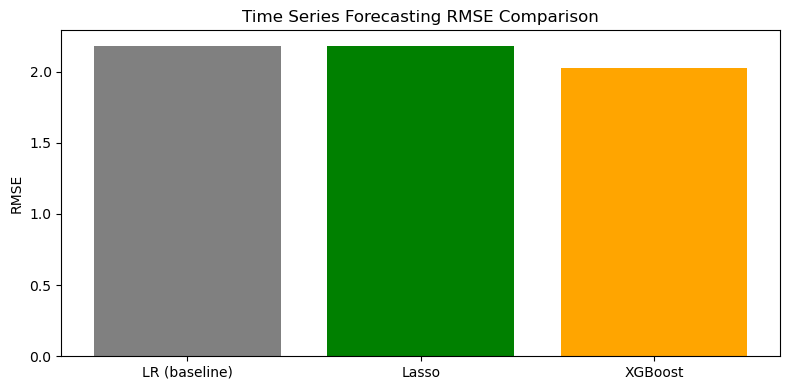

In [18]:
plt.figure(figsize=(8,4))
plt.bar(results["Model"], results["RMSE"], color=["gray","green","orange"])
plt.ylabel("RMSE")
plt.title("Time Series Forecasting RMSE Comparison")
plt.tight_layout()
plt.show()

## Forecasting Result Visualization

We visualize the model outputs to understand forecasting behavior:
- Full time-series plot of value_0
- Forecast vs Actual plot for the test set
- ACF (Autocorrelation) plot to show how past values influence future values
- Zoomed window to view short-term fluctuations and spikes.

These visualizations support model interpretation.

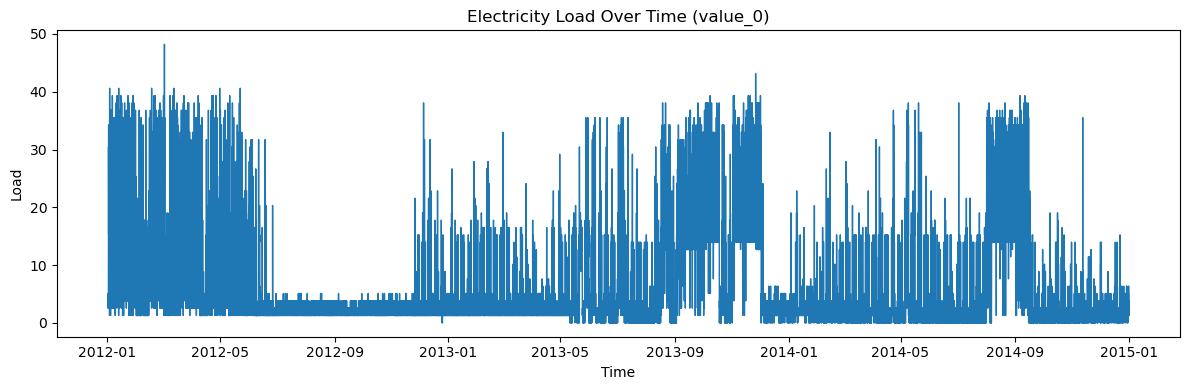

In [19]:
plt.figure(figsize=(12,4))
plt.plot(ts["timestamp"], ts["value_0"], linewidth=1)
plt.title("Electricity Load Over Time (value_0)")
plt.xlabel("Time")
plt.ylabel("Load")
plt.tight_layout()
plt.show()

## Autocorrelation Structure of value_0

This plot shows the correlation between value_0 and its lagged values.
A slow decay in autocorrelation indicates strong short-term memory in the series, which motivates the lag choices and explains why forecasting models perform well with these engineered features.

<Figure size 1000x400 with 0 Axes>

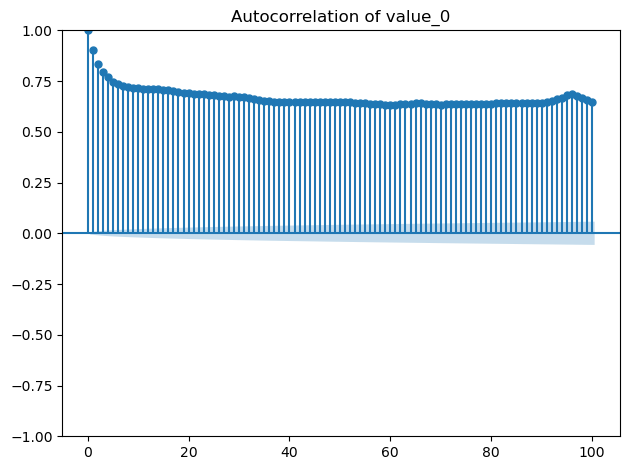

In [20]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10,4))
plot_acf(ts["value_0"], lags=100)
plt.title("Autocorrelation of value_0")
plt.tight_layout()
plt.show()

## Zoomed-In View of Short-Term Load Patterns

To better understand fine-grained behavior, we zoom into a one-month window (June 2014).
This helps reveal high-frequency fluctuations, sudden spikes, and short bursts of activity that are not visible in the full time-series plot.
These localized patterns explain why nonlinear models like XGBoost perform better than linear baselines.

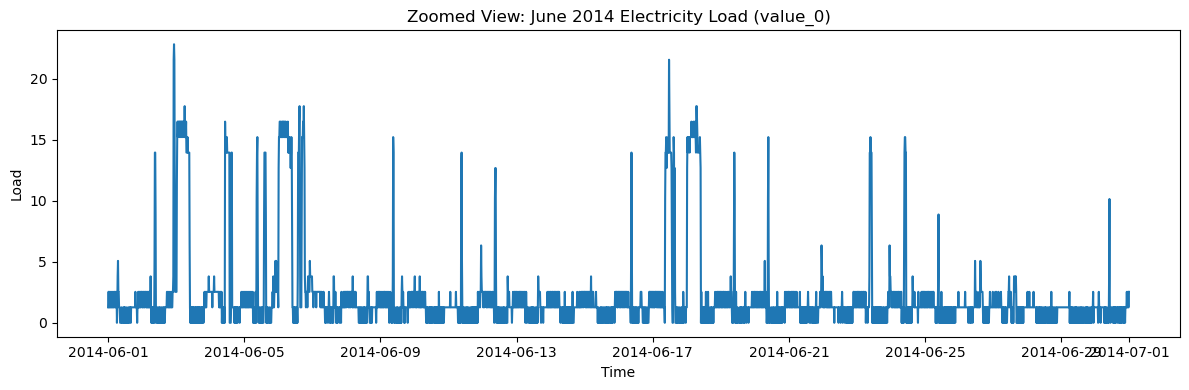

In [21]:
subset = ts[(ts["timestamp"] >= "2014-06-01") & (ts["timestamp"] < "2014-07-01")]

plt.figure(figsize=(12,4))
plt.plot(subset["timestamp"], subset["value_0"])
plt.title("Zoomed View: June 2014 Electricity Load (value_0)")
plt.xlabel("Time")
plt.ylabel("Load")
plt.tight_layout()
plt.show()

## Interpretation & Conclusion

### Model Performance Summary
* XGBoost achieved the lowest RMSE, indicating nonlinear dependencies in the load time series.
* Lasso and Linear Regression performed similarly, suggesting limited benefit from regularization in this simple lag-based configuration.
* RMSE values are much lower than the regression notebook because here we predict one meter from its own history, which is far easier.

### Takeaways
* Electricity load shows strong temporal structure (daily/weekly cycles).
* Lag-based features are highly effective for short-term forecasting.
* Complex models like XGBoost offer modest improvements over linear baselines.
